In [1]:
import os
import pandas as pd
import numpy as np
import math
import pickle
import codecs
from progressBar import printProgressBar
import argparse
import shutil

#Following code is for debugging

try :
  parser = argparse.ArgumentParser()
  parser.add_argument('--force-retrain', help="Set value to 1 if you wish to retrain the models.")
  parser.add_argument('--debug', help="Debug.")
  args = parser.parse_args()
  force_retrain = args.force_retrain
  debug = args.debug

except :
  force_retrain = None
  debug = None

try :
    shutil.unpack_archive("models.zip", "models", "zip")

except :
    pass

print ("Done.")

usage: ipykernel_launcher.py [-h] [--force-retrain FORCE_RETRAIN]
                             [--debug DEBUG]
ipykernel_launcher.py: error: unrecognized arguments: -f C:\Users\ASUS\AppData\Roaming\jupyter\runtime\kernel-0132b4f5-9078-4851-9c03-d762eacfe24a.json


Done.


In [2]:
with codecs.open("amazon_dataset_1.csv", "r",encoding='utf-8', errors='ignore') as file_dat:
     dataset = pd.read_csv(file_dat)

len_dataset = math.floor(len(dataset)/1)

y = dataset.iloc[:,1:2].values

print ("Done.")

Done.


In [16]:
import nltk

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('maxent_treebank_pos_tagger')
nltk.download('averaged_perceptron_tagger')
# nltk.download()

print("\n---------------------------------------------------------------------------------------\n")

import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

print ("Done.")


---------------------------------------------------------------------------------------

Done.


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package maxent_treebank_pos_tagger to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_treebank_pos_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


---
#### **Tokenization and Stemming**
---


In [17]:
print ("\nPerforming Tokenization and Stemming.")
load_from_disk = False
corpus=[]
num = 0

for i in range(0, math.floor(len_dataset)) :
    if not debug :
        printProgressBar(iteration = num, total = len_dataset, prefix = 'Progress:', suffix = 'Complete', length = 50)
        num = num + 1

    if os.path.exists(os.path.join("models", "corpus.sav")) and force_retrain == None :
        load_from_disk = True
        continue


    review = re.sub('[^a-zA-Z]',' ',dataset['REVIEW_TEXT'][i])
    review = review.lower()
    review = review.split()
    #print (review)
    review = [word for word in review if not word in set(stopwords.words('english'))]
    ps = PorterStemmer()
    review = [ps.stem(word) for word in review if not word in set(stopwords.words('english'))]
    review = ' '.join(review)
    corpus.append(review)

filename = 'corpus.sav'
if load_from_disk == False :
    pickle.dump(corpus, open(os.path.join("models", filename), 'wb'))

if load_from_disk :
    corpus = pickle.load(open(os.path.join("models", filename), 'rb'))


Performing Tokenization and Stemming.
100.0% Completed.

---
#### **Count Vectorization**
---


In [18]:
from sklearn.feature_extraction.text import CountVectorizer
cv=CountVectorizer(max_features=3000)
X=cv.fit_transform(corpus).toarray()
y=dataset.iloc[:len_dataset,1]

filename = 'countvectorizer.sav'
pickle.dump(cv, open(os.path.join("models", filename), 'wb'))

print ("Done.")

Done.


---
#### **POS Tagging**
---


In [19]:
def POS_Tagging(sentence):
    tagged_list = []
    tags = []
    count_verbs = 0
    count_nouns = 0
    text=nltk.word_tokenize(sentence)
    tagged_list = (nltk.pos_tag(text))

    tags = [x[1] for x in tagged_list]
    for each_item in tags:
        if each_item in ['VERB','VB','VBN','VBD','VBZ','VBG','VBP']:
            count_verbs+=1
        elif each_item in ['NOUN','NNP','NN','NUM','NNS','NP','NNPS']:
            count_nouns+=1
        else:
            continue
    if count_verbs > count_nouns:
        sentence = 'F'
    else:
        sentence = 'T'

    return sentence

w, h = 2, len_dataset;
pos_tag = [[0 for x in range(w)] for y in range(h)]
num = 0

load_from_disk = False
filename = 'pos_tag.sav'
print ("\n\nPerforming POS Tagging.")
for i in range(0,len_dataset):
    if not debug :
        printProgressBar(iteration = num, total = len_dataset, prefix = 'Progress:', suffix = 'Complete', length = 50)
        num = num + 1

    if os.path.exists(os.path.join("models", filename)) and force_retrain == None :
        load_from_disk = True
        continue

    text = dataset['REVIEW_TEXT'][i]
    sentence = POS_Tagging(text)

    if sentence == 'T':
        pos_tag[i][0] = 1
        pos_tag[i][1] = 0
    else:
        pos_tag[i][0] = 0
        pos_tag[i][1] = 1


if load_from_disk == False :
    pickle.dump(pos_tag, open(os.path.join("models", filename), 'wb'))

if load_from_disk :
    pos_tag = pickle.load(open(os.path.join("models", filename), 'rb'))

X = np.append(X, pos_tag, axis = 1)



Performing POS Tagging.
100.0% Completed.

---
####**Label Encoding**
---

In [20]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer

le = LabelEncoder()
y = le.fit_transform(y)

w, h = 3, len_dataset;
new_col = [[0 for x in range(w)] for y in range(h)]
num = 0

test = dict()
test_num = 0

for i in range(0, len_dataset):
    new_col[i][0] = dataset["RATING"][i]
    new_col[i][1] = dataset["VERIFIED_PURCHASE"][i]
    new_col[i][2] = dataset["PRODUCT_CATEGORY"][i]

    if new_col[i][2] not in test.keys() :
        test[new_col[i][2]] = 1
        test_num = test_num + 1


new_col = np.array(new_col)

labelEncoder = LabelEncoder()
new_col[:, 0] = labelEncoder.fit_transform(new_col[:, 0])
filename = 'labelencoder_1.sav'
pickle.dump(labelEncoder, open(os.path.join("models", filename), 'wb'))

new_col[:, 1] = labelEncoder.fit_transform(new_col[:, 1])
filename = 'labelencoder_2.sav'
pickle.dump(labelEncoder, open(os.path.join("models", filename), 'wb'))

new_col[:, 2] = labelEncoder.fit_transform(new_col[:, 2])
filename = 'labelencoder_3.sav'
pickle.dump(labelEncoder, open(os.path.join("models", filename), 'wb'))

print ("Done.")

Done.


---
####**OneHotEncoder / Column Transformer**
---

In [21]:
ct1 = ColumnTransformer([("Rating", OneHotEncoder(), [0])], remainder = 'passthrough')
new_col = ct1.fit_transform(new_col)
new_col = new_col.astype(np.float32)
filename = 'columntransformer1.sav'
pickle.dump(ct1, open(os.path.join("models", filename), 'wb'))

ct2 = ColumnTransformer([("Verified Purchase", OneHotEncoder(), [5])], remainder = 'passthrough')
new_col = ct2.fit_transform(new_col)
new_col = new_col.astype(np.float32)
filename = 'columntransformer2.sav'
pickle.dump(ct2, open(os.path.join("models", filename), 'wb'))

ct3 = ColumnTransformer([("Category", OneHotEncoder(), [7])], remainder = 'passthrough')
new_col = ct3.fit_transform(new_col)
new_col = new_col.toarray()
new_col = new_col.astype(np.float32)
filename = 'columntransformer3.sav'
pickle.dump(ct3, open(os.path.join("models", filename), 'wb'))

new_col = new_col.astype(np.uint8)
X = X.astype(np.uint8)
X = np.append(X, new_col, axis=1).astype(np.uint8)

print ("Done.")

Done.


---
####**Split in Train and Test Set**
---

In [22]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

print ("Done.")

Done.


---
####**Training Classifiers**
---

In [23]:
print ("\n\nTraining Classifier on Bernoulli Naive Bayes.")

from sklearn.naive_bayes import BernoulliNB

bernoullinb = None
if os.path.exists(os.path.join("models", "bernoullinb.sav")) and force_retrain == None:
    bernoullinb = pickle.load(open(os.path.join("models", "bernoullinb.sav"), "rb"))

else :
    bernoullinb = BernoulliNB(alpha = 1.0, binarize = 0.0, fit_prior = True, class_prior = None)
    bernoullinb.fit(X_train,y_train)

    filename = 'bernoullinb.sav'
    pickle.dump(bernoullinb, open(os.path.join("models", filename), 'wb'))

print("Done.")

y_pred_bernoulli = bernoullinb.predict(X_test)

from sklearn.metrics import accuracy_score
print ("\nAccuracy of Bernoulli Naive Bayes is : ")
print (accuracy_score(y_test, y_pred_bernoulli) * 100)

print ("\n\nTraining Classifier on Support Vector Machine.")
from sklearn.svm import SVC # "Support Vector Classifier"

clf = None

if os.path.exists(os.path.join("models", "SVM.sav")) and force_retrain == None:
    clf = pickle.load(open(os.path.join("models", "SVM.sav"), "rb"))
    y_pred_svc = pickle.load(open(os.path.join("models", "SVM_y_pred.sav"), "rb"))

else :
    clf = SVC(kernel='rbf')
    clf.fit(X_train, y_train)

    filename = 'SVM.sav'
    pickle.dump(clf, open(os.path.join("models", filename), 'wb'))

    y_pred_svc = clf.predict(X_test)
    pickle.dump(y_pred_svc, open(os.path.join("models", "SVM_y_pred.sav"), 'wb'))

print("Done.")

shutil.make_archive("models", 'zip', "models")

from sklearn.metrics import accuracy_score
print ("\nAccuracy of Support Vector Machine is : ")
print(accuracy_score(y_test, y_pred_svc) * 100)



Training Classifier on Bernoulli Naive Bayes.
Done.

Accuracy of Bernoulli Naive Bayes is : 
70.16666666666667


Training Classifier on Support Vector Machine.
Done.

Accuracy of Support Vector Machine is : 
80.11904761904762


---
####**Plot Graphs**
---

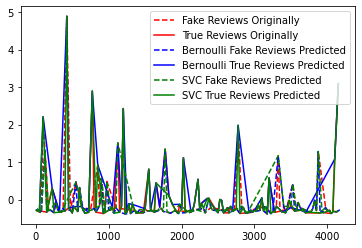

In [24]:
from graph import plot2d, plot_comp

X = np.concatenate((X_train, X_test))
y = np.concatenate((y_train, y_test))

plot2d(X_test, y_test, y_pred_bernoulli, y_pred_svc)